# Try scaling capacity factors so that bias in power is zero

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# client.close()
# cluster.close()

In [14]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "02:00:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52+scratch/dt6"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [15]:
cluster.scale(jobs=1)
client = Client(cluster)

In [16]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.65:43823,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import xarray as xr
import pandas as pd

In [3]:
%cd /g/data/w42/dr6273/work/power_models
import functions as fn

/g/data/w42/dr6273/work/power_models


In [4]:
%load_ext autoreload
%autoreload 2

# Load obs

In [5]:
def open_aemo_obs(fuel_type, year, months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]):
    """
    Open monthly data and concatenate
    
    fuel_type: str, "wind" or "solar"
    year: str, year to open.
    months: list, each element a 2-character string indicating the month, e.g. '01', '02'.
    """
    df_list = []
    for month in months:
        df = pd.read_csv(
            "/scratch/w42/dr6273/processed_AEMO/aemo_hourly_" + fuel_type + "_" + year + "_" + month + ".csv",
            index_col=[0,1]
        )
        df_list.append(df)
        
    return pd.concat(df_list, axis=0)

In [6]:
def df_to_xarray(df):
    """
    Convert AEMO obs dataframe to xarray
    """
    # Convert to xarray DataSet
    ds = df.to_xarray()
    # Rename dimensions and variable name
    ds = ds.rename({"Region": "region", "SETTLEMENTDATE": "time", "INITIALMW": "power"})
    # Ensure coordinates are correct data type
    ds = ds.assign_coords({
        "region": ["NSW", "QLD", "SA", "TAS", "VIC"],
        "time": pd.to_datetime(ds["time"]) - pd.DateOffset(hours=10)
    })
    # Re-order region coordinate to match modelled data
    ds = ds.reindex({"region": ["NSW", "QLD", "VIC", "SA", "TAS"]})
    
    return ds

In [7]:
wind_list = []
solar_list = []

months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

for year in ["2020", "2021", "2022", "2023"]:
    # We want December 2020 - November 2023
    # These data are in AEST so we need an extra month at the end (December 2023)
    if year == "2020":
        m = ["12"]
    else:
        m = months
        
    w = open_aemo_obs("wind", year, m)
    w_da = df_to_xarray(w).compute()
    wind_list.append(w_da)
    
    s = open_aemo_obs("solar", year, m)
    # Pad with NaNs for TAS
    s = s.reindex_like(w)
    s_da = df_to_xarray(s).compute()
    solar_list.append(s_da)

In [8]:
aemo_wind = xr.concat(wind_list, dim="time")
aemo_solar = xr.concat(solar_list, dim="time")

In [9]:
# aemo_wind = aemo_wind.sel(time=slice("2020-12", "2023-11"))
# aemo_solar = aemo_solar.sel(time=slice("2020-12", "2023-11"))

In [216]:
# This looks correct!
aemo_solar.power.sum("region").resample(time="1YS").sum()/1e6

<xarray.DataArray 'power' (time: 4)> Size: 32B
array([ 0.79153541,  8.65201029, 11.71452815, 14.38322688])
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-01-01 2021-01-01 ... 2023-01-01

In [223]:
# So 2023 values for each state:
aemo_solar.power.sel(time="2023").sum("time")/1e6

<xarray.DataArray 'power' (region: 5)> Size: 40B
array([6.22952472, 5.75254219, 1.54508039, 0.85607958, 0.        ])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'

In [217]:
# This is close - should be 21, 25, 27
aemo_wind.power.sum("region").resample(time="1YS").sum()/1e6

<xarray.DataArray 'power' (time: 4)> Size: 32B
array([ 1.63755269, 19.87762103, 25.357558  , 25.35061304])
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-01-01 2021-01-01 ... 2023-01-01

In [224]:
# So 2023 values for each state:
aemo_wind.power.sel(time="2023").sum("time")/1e6

<xarray.DataArray 'power' (region: 5)> Size: 40B
array([5.35971849, 2.60372814, 9.65689535, 6.30046057, 1.42981049])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'

# Load modelled site power

In [189]:
years = range(1940, 2024)

In [188]:
fp = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

In [202]:
wind_power = xr.open_mfdataset(
    fp + "wind/power/wind_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [203]:
wind_power = wind_power.sel(
    region = ["NSW", "QLD", "SA", "TAS", "VIC"],
    time=slice("2020-12", "2023-12")
)

In [204]:
solar_power = xr.open_mfdataset(
    fp + "solar/power/solar_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [205]:
solar_power = solar_power.sel(
    region=["NSW", "QLD", "SA", "TAS", "VIC"],
    time=slice("2020-12", "2023-12")
)

In [211]:
wind_power.sel(time="2023").sum("time").compute() / 1e6

<xarray.DataArray 'power' (region: 5)> Size: 20B
array([2.881205 , 0.6788255, 3.9969509, 1.4574883, 4.746232 ],
      dtype=float32)
Coordinates:
  * region             (region) <U3 60B 'NSW' 'QLD' 'SA' 'TAS' 'VIC'
    scale_factor_2023  (region) float64 40B 1.998 3.838 1.577 1.297 2.392

In [212]:
solar_power.sel(time="2023").sum("time").compute() / 1e6

<xarray.DataArray 'power' (region: 5)> Size: 20B
array([7.798525 , 6.1763053, 0.8843482, 0.       , 1.8952496],
      dtype=float32)
Coordinates:
  * region             (region) <U3 60B 'NSW' 'QLD' 'SA' 'TAS' 'VIC'
    scale_factor_2023  (region) float64 40B 0.8166 0.9464 0.9329 1.0 0.8157

In [214]:
solar_power.sel(time="2023").sum("time").sum().compute() / 1e6

<xarray.DataArray 'power' ()> Size: 8B
array(16.754428)

# Load modelled REZ power

#### REZ mask

In [17]:
mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

#### REZ generation

In [18]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [19]:
# Tidy column names
_gen.columns = [i.replace("90", "9-") for i in _gen.columns]
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [20]:
# Sum scenarios with existing capacity
gen = _gen.copy()
for col in _gen.columns[2:]:
    if col[:3] == "Exi":
        pass
    else:
        gen_type = col.split("_")[-2]
        gen[col] = _gen[col] + _gen["Existing_" + gen_type]

In [21]:
gen = gen[["Existing_solar", "Existing_wind"]]

### Pre-compute capacity factor averages:

In [22]:
def calculate_mean_cf(years, gen_type, method="van_der_Wiel", chunks=None):
    """
    Return mean capacity factor over all years
    
    gen_type: str, 'wind' or 'solar'
    method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
    chunks: dict, how to chunk. Default is None
    """
    da_list = []
    for year in years:
        cf = fn.load_hourly_cf(year, gen_type, method=method, chunks={"lat": 75, "lon": 100, "time": -1}).capacity_factor
        cf = cf.mean("time").expand_dims({"time": [year]})
        da_list.append(cf)
    cf = xr.concat(da_list, dim="time")
    return cf.mean("time")

In [25]:
compute = False

In [26]:
if compute:
    for gen_type in ["wind", "solar"]:
        mean_cf = calculate_mean_cf(years, gen_type)
        mean_cf.to_dataset(name="capacity_factor").to_netcdf(
            fp + gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
        )
        # mean_cf_2011_23 = calculate_mean_cf(range(2011, 2024), gen_type)
        # mean_cf_2011_23.to_dataset(name="capacity_factor").to_netcdf(
        #     fp + gen_type + "_mean_capacity_factor_2011_2023_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
        # )

# Compute generation

In [27]:
def get_even_capacity_mask(mask_da, generation):
    """
    Return DataArray with mask of capacity divided evenly across grid cells
    
    mask_da: array of REZ mask
    generation: pandas Series of capacity values for each region (index).
    """
    da_list = []
    for r in generation.index:
        capacity = generation.loc[r]
        n_cells = mask_da.sel(region=r).sum().values
        
        da = mask_da.sel(region=r).where(
            mask_da.sel(region=r) == 0,
            capacity / n_cells
        ).expand_dims({"REZ": [r]})
        
        da_list.append(da)
        
    return xr.concat(da_list, dim="REZ")

In [28]:
def get_cf_scaled_capacity_mask(cf_mean, mask_da, generation):
    """
    Return DataArray with mask of capacity divided according to weights from average capacity factor
    
    cf_mean: array of capacity factor weights
    mask_da: array of REZ mask
    generation: pandas Series of capacity values for each region (index).
    """
    da_list = []
    for r in generation.index:
        capacity = generation.loc[r]
        
        cf_region = cf_mean.where(
            mask_da.sel(region=r) == 1,
            drop=True
        )
        weights = cf_region / cf_region.sum()
        
        tolerance = 0.01
        if 1 - weights.sum().values > tolerance:
            print(weights.sum().values)
            raise ValueError("Weights don't sum to one.")
            
        da = (weights * capacity).expand_dims({"REZ": [r]})
        
        da_list.append(da)
        
    return xr.concat(da_list, dim="REZ")

In [29]:
def calc_generation(capacity_factor, generation_capacity, capacity_factor_scaling=None):
    """
    Return DataArray with time series of power for each REZ
    
    capacity_factor: DataArray of capacity factors
    generation_capacity: DataArray of each grid cells generation capacity
    capacity_factor_scaling: DataArray of scale factors for capacity factor
    """
    da_list = []
    for r in generation_capacity.REZ.values:
        r_mask = generation_capacity.sel(REZ=r).where(
            generation_capacity.sel(REZ=r) > 0, drop=True
        )
        
        # Apply monthly bias correction if desired
        if capacity_factor_scaling is not None:
            if r[:1] == "N":
                region_scalings = capacity_factor_scaling.sel(region="NSW")
            elif r[:1] == "Q":
                region_scalings = capacity_factor_scaling.sel(region="QLD")
            elif r[:1] == "V":
                region_scalings = capacity_factor_scaling.sel(region="VIC")
            elif r[:1] == "S":
                region_scalings = capacity_factor_scaling.sel(region="SA")
            elif r[:1] == "T":
                region_scalings = capacity_factor_scaling.sel(region="TAS")
            else:
                raise ValueError("Incorrect r")
            
            capacity_factor_scaled = capacity_factor.groupby("time.month") * region_scalings
            da = capacity_factor_scaled * r_mask
        else:
            # Or use raw data
            da = capacity_factor * r_mask
            
        da = da.sum(["lat", "lon"])
        da = da.expand_dims({"REZ": [r]})

        da_list.append(da)

    return xr.concat(da_list, dim="REZ")

In [30]:
def calc_all_years_generation(years, mask_da, generation, capacity_factor_scaling=None, scale_mask="capacity_factor", method="van_der_Wiel", add_dir=""):
    """
    Compute power time series for each REZ and each year.
    
    years: range
    mask_da: array, mask of REZs
    generation: pandas Series with index as REZ ID and values as generation capacity
    capacity_factor_scaling: array with month and region dimensions, default None
    scale_mask: str, 'capacity_factor' to scale by mean capacity factors,
        'even' for an even distribution of generation amongst REZ cells,
        'none' to use mask_da directly.
    method: str, which method of capacity factors was used
    add_dir, add_dir: str, additional directory for load_hourly_cf, default ""
    """
    def _get_gen_type(gen):
        g_split = gen.name.split("_")
        if g_split[0] == "Solar":
            gt = "solar"
        elif g_split[0] == "Wind":
            gt = "wind"
        elif g_split[0] == "Existing":
            gt = g_split[1]
        else:
            gt = g_split[-2]
        return gt
    
    gen_type = _get_gen_type(generation)
    
    if scale_mask == "capacity_factor": # Use mean capacity factor weights to split the generation capacities by
        mean_cf = xr.open_dataset(
            "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + \
            gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_1940-2023.nc"
        )["capacity_factor"]
        
        gen_capacity = get_cf_scaled_capacity_mask(mean_cf, mask_da, generation)
        
    elif scale_mask == "even": # Divide the generation capacity by the size of the region and assign each cell that number
        gen_capacity = get_even_capacity_mask(mask_da, generation)
        
    else: # Just use mask_da as the generation capacities for each cell
        gen_capacity = mask_da.copy()
    
    da_list = []
    for year in years:
        cf = fn.load_hourly_cf(year, gen_type, method=method, add_dir=add_dir, chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
        p = calc_generation(cf, gen_capacity, capacity_factor_scaling=capacity_factor_scaling)
        da_list.append(p)
    REZ_power = xr.concat(da_list, dim="time")
    REZ_power = REZ_power.chunk({"REZ": -1, "time": -1})
    
    return REZ_power

In [31]:
def get_REZ_for_state(ds, state):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds.REZ.values if i[0] == state[0]]

In [32]:
def sum_REZ_power_for_states(ds, states=["NSW", "QLD", "VIC", "SA", "TAS"]):
    """
    Return array of ds summed for each REZ in each state
    
    ds: dataset with REZ dimension
    states: list, of strings of states
    """
    da_list = []
    for state in states:
        r = get_REZ_for_state(ds, state)
        da = ds.sel(REZ=r).sum("REZ").expand_dims({"region": [state]})
        da_list.append(da)
    return xr.concat(da_list, dim="region")

In [33]:
years = range(2020, 2024)

In [34]:
obs_dict = {
    "Existing_wind": aemo_wind.power,
    "Existing_solar": aemo_solar.power
}

In [33]:
%%time
data_dict = {}
bias_dict = {}
for scenario in ["Existing_wind", "Existing_solar"]:
    print(scenario)
    gen_ds = calc_all_years_generation(years, mask, gen[scenario])
    # gen_ds = gen_ds.to_dataset(name="power")
    
    gen_ds = gen_ds.sel(time=slice("2020-12", "2023-11"))
    model_data = sum_REZ_power_for_states(gen_ds).compute()
    
    # Monthly climatology
    obs_clim = obs_dict[scenario].groupby("time.month").mean()
    mod_clim = model_data.groupby("time.month").mean()
    bias = obs_clim / mod_clim
    
    data_dict[scenario] = model_data
    bias_dict[scenario] = bias

Existing_wind
Existing_solar
CPU times: user 14 s, sys: 959 ms, total: 14.9 s
Wall time: 19.3 s


### Compare observations and model

In [34]:
bias_dict["Existing_wind"]

<xarray.DataArray (region: 5, month: 12)> Size: 480B
array([[3.4410366 , 3.53424963, 3.56635754, 3.95487952, 3.92526336,
        4.30313231, 3.26102126, 3.58293697, 3.1917721 , 3.11158145,
        3.10482765, 2.93902892],
       [0.88144431, 0.89753509, 1.00039167, 0.84870012, 0.90954243,
        1.15788898, 0.89911022, 1.02849149, 0.92922075, 0.94591132,
        1.00940774, 0.83590484],
       [1.17885304, 1.23406243, 1.22393474, 1.08966425, 0.93581314,
        1.21909266, 0.92192738, 0.96299175, 0.8895142 , 0.94228968,
        1.07245606, 0.98904826],
       [1.98082802, 1.9130735 , 2.23251197, 1.98862351, 1.77208121,
        1.82110936, 1.3963498 , 1.41683712, 1.30783529, 1.48817187,
        1.51672068, 1.61771138],
       [1.59933137, 1.54328383, 1.49488177, 1.62720029, 1.45844539,
        1.58507988, 1.37395345, 1.39978432, 1.33686878, 1.24625672,
        1.44175144, 1.43130143]])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [15]:
aemo_solar.power.sel(region="NSW").resample(time="1YS").sum()/1e6

<xarray.DataArray 'power' (time: 4)> Size: 32B
array([0.29286316, 3.3872432 , 5.09971371, 6.22952472])
Coordinates:
    region   <U3 12B 'NSW'
  * time     (time) datetime64[ns] 32B 2020-01-01 2021-01-01 ... 2023-01-01

In [35]:
bias_dict["Existing_solar"]

<xarray.DataArray (region: 5, month: 12)> Size: 480B
array([[0.58400013, 0.64257214, 0.66044386, 0.67798801, 0.72733981,
        0.8419752 , 0.78490163, 0.78334173, 0.73090474, 0.61051946,
        0.68474421, 0.57286389],
       [0.69259214, 0.7445253 , 0.72745185, 0.76379941, 0.84930497,
        0.99680195, 0.91161511, 0.81501783, 0.71474013, 0.74629635,
        0.84853617, 0.68805893],
       [0.48719   , 0.54060468, 0.53575531, 0.66267239, 0.69234423,
        0.72112947, 0.68794948, 0.65830759, 0.55491724, 0.49574567,
        0.5103694 , 0.43890189],
       [0.47394131, 0.51301143, 0.52803406, 0.61448704, 0.64932872,
        0.74364944, 0.66700831, 0.60993145, 0.49514193, 0.42001815,
        0.44325918, 0.42243432],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
data_dict["Existing_wind"].sum("region").resample(time="1MS").sum().coarsen(time=12).sum()

<xarray.DataArray 'capacity_factor' (time: 3)> Size: 12B
array([17556776., 16213055., 15873741.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 24B 2021-05-17T02:00:00 ... 2023-05-17T02:...

In [16]:
data_dict["Existing_solar"]#.sum("region").resample(time="1MS").sum().coarsen(time=12).sum()

NameError: name 'data_dict' is not defined

### Use these biases to correct capacity factors and recalculate power

In [38]:
%%time
scaled_data_dict = {}
scaled_bias_dict = {}
for scenario in ["Existing_wind", "Existing_solar"]:
    print(scenario)
    _bias = bias_dict[scenario]
    gen_ds = calc_all_years_generation(years, mask, gen[scenario], capacity_factor_scaling=_bias)
    
    gen_ds = gen_ds.sel(time=slice("2020-12", "2023-11"))
    model_data = sum_REZ_power_for_states(gen_ds).compute()
    
    # Monthly climatology
    obs_clim = obs_dict[scenario].groupby("time.month").mean()
    mod_clim = model_data.groupby("time.month").mean()
    bias = obs_clim / mod_clim
    
    scaled_data_dict[scenario] = model_data
    scaled_bias_dict[scenario] = bias

Existing_wind
Existing_solar
CPU times: user 54.9 s, sys: 2.69 s, total: 57.6 s
Wall time: 1min


In [39]:
scaled_bias_dict["Existing_wind"]

<xarray.DataArray (region: 5, month: 12)> Size: 480B
array([[0.99999943, 1.00000158, 1.00000037, 0.99999997, 0.99999925,
        1.00000062, 1.00000009, 1.00000028, 0.99999964, 0.99999938,
        0.99999929, 0.9999992 ],
       [1.00000051, 0.99999973, 0.99999948, 1.00000046, 1.00000015,
        1.00000084, 0.99999908, 1.00000158, 0.99999831, 0.9999997 ,
        0.99999909, 0.99999992],
       [1.0000006 , 0.99999951, 0.99999915, 0.99999934, 0.99999985,
        0.99999981, 1.00000029, 0.99999942, 1.0000002 , 0.99999985,
        0.99999965, 0.99999937],
       [0.99999937, 0.99999945, 0.99999982, 0.99999973, 0.99999865,
        0.99999975, 1.00000093, 1.00000075, 0.99999979, 0.99999987,
        1.00000029, 1.00000047],
       [1.00000065, 1.00000115, 0.99999893, 1.00000017, 0.99999955,
        1.0000011 , 1.00000076, 1.00000034, 1.0000008 , 1.0000007 ,
        0.99999932, 0.99999965]])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [41]:
scaled_bias_dict["Existing_solar"]

<xarray.DataArray (region: 5, month: 12)> Size: 480B
array([[1.00000095, 1.00000045, 1.00000023, 1.00000003, 1.00000039,
        1.00000032, 1.00000016, 0.99999986, 1.00000113, 0.99999989,
        1.00000094, 0.99999992],
       [0.99999963, 1.00000032, 1.00000041, 1.00000046, 0.99999999,
        1.00000071, 1.00000009, 0.99999935, 0.99999986, 1.00000002,
        1.00000012, 1.00000007],
       [1.00000051, 1.00000001, 0.99999959, 0.9999999 , 0.99999909,
        1.00000033, 1.00000065, 1.00000027, 1.00000045, 0.99999936,
        1.00000004, 1.00000057],
       [1.00000015, 0.99999992, 0.99999989, 1.00000067, 1.00000081,
        0.99999927, 1.00000007, 0.99999991, 0.99999989, 1.00000031,
        0.99999903, 1.00000008],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [45]:
scaled_data_dict["Existing_wind"].sum("region").resample(time="1MS").sum().coarsen(time=12).sum() / 1e6

<xarray.DataArray (time: 3)> Size: 24B
array([24.60804387, 23.2767485 , 22.21410409])
Coordinates:
  * time     (time) datetime64[ns] 24B 2021-05-17T02:00:00 ... 2023-05-17T02:...

In [46]:
scaled_data_dict["Existing_solar"].sum("region").resample(time="1MS").sum().coarsen(time=12).sum() / 1e6

<xarray.DataArray (time: 3)> Size: 24B
array([11.23986493, 10.90891902, 11.77341512])
Coordinates:
  * time     (time) datetime64[ns] 24B 2021-05-17T02:00:00 ... 2023-05-17T02:...

#### Write biases to file

In [49]:
bias_dict

{'Existing_wind': <xarray.DataArray (region: 5, month: 12)> Size: 480B
 array([[3.4410366 , 3.53424963, 3.56635754, 3.95487952, 3.92526336,
         4.30313231, 3.26102126, 3.58293697, 3.1917721 , 3.11158145,
         3.10482765, 2.93902892],
        [0.88144431, 0.89753509, 1.00039167, 0.84870012, 0.90954243,
         1.15788898, 0.89911022, 1.02849149, 0.92922075, 0.94591132,
         1.00940774, 0.83590484],
        [1.17885304, 1.23406243, 1.22393474, 1.08966425, 0.93581314,
         1.21909266, 0.92192738, 0.96299175, 0.8895142 , 0.94228968,
         1.07245606, 0.98904826],
        [1.98082802, 1.9130735 , 2.23251197, 1.98862351, 1.77208121,
         1.82110936, 1.3963498 , 1.41683712, 1.30783529, 1.48817187,
         1.51672068, 1.61771138],
        [1.59933137, 1.54328383, 1.49488177, 1.62720029, 1.45844539,
         1.58507988, 1.37395345, 1.39978432, 1.33686878, 1.24625672,
         1.44175144, 1.43130143]])
 Coordinates:
   * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 

In [50]:
for scenario in ["Existing_wind", "Existing_solar"]:
    bias_dict[scenario].to_dataset(name="bias").to_netcdf(
        fp + scenario + "_multiplicative_bias_202012-202311.nc"
    )

# Problem solving

In [41]:
# Sum scenarios with existing capacity
gen = _gen.copy()
for col in _gen.columns[2:]:
    if col[:3] == "Exi":
        pass
    else:
        gen_type = col.split("_")[-2]
        gen[col] = _gen[col] + _gen["Existing_" + gen_type]

In [119]:
gen_type = "solar"

In [120]:
mean_cf = xr.open_dataset(
            "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + \
            gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_1940-2023.nc"
        )["capacity_factor"]

In [121]:
import matplotlib.pyplot as plt

In [122]:
method="van_der_Wiel"

In [123]:
gen_capacity_current = get_cf_scaled_capacity_mask(mean_cf, mask, gen["Existing_solar"])

In [124]:
gen_capacity_30 = get_cf_scaled_capacity_mask(mean_cf, mask, gen["Step_change_solar_2029-30"])

In [125]:
year="2023"

In [126]:
cf = fn.load_hourly_cf(year, gen_type, method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor 

For all NSW

In [127]:
r = ["N"+str(i) for i in range(1, 13)]

In [128]:
r_mask_current = gen_capacity_current.sel(REZ=r).where(gen_capacity_current.sel(REZ=r).notnull(), drop=True)
r_mask_30 = gen_capacity_30.sel(REZ=r).where(gen_capacity_30.sel(REZ=r).notnull(), drop=True)

In [129]:
r_mask_current = r_mask_current.sum("REZ")
r_mask_30 = r_mask_30.sum("REZ")

Text(0.5, 1.0, '2030, MW: 7499.0')

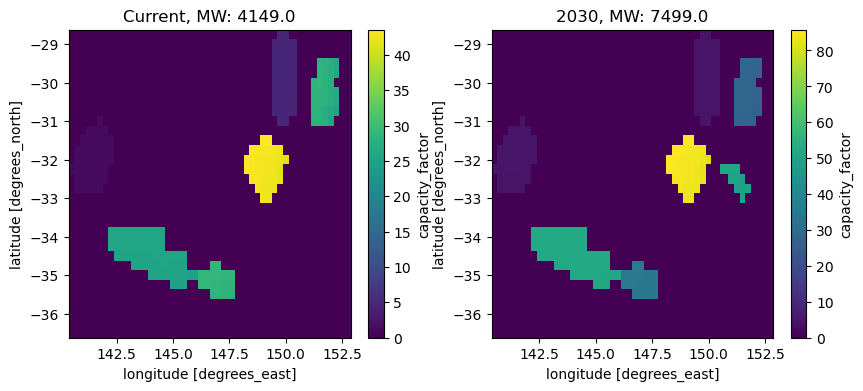

In [130]:
fig,ax=plt.subplots(1, 2, figsize=(10,4))
r_mask_current.plot(ax=ax[0])
ax[0].set_title("Current, MW: " + str(gen_capacity_current.sel(REZ=r).sum().values))

r_mask_30.plot(ax=ax[1])
ax[1].set_title("2030, MW: " + str(gen_capacity_30.sel(REZ=r).sum().values))

In [131]:
cf_r = cf.where(r_mask_current > 0, drop=True).compute()

In [138]:
power_current = (cf_r * r_mask_current) / 1e6
power_30 = (cf_r * r_mask_30) / 1e6

# power_current_bc = cf_r_bc * r_mask_current / 1e6
# power_30_bc = cf_r_bc * r_mask_30 / 1e6

# power_current_bc_clip = cf_r_bc_clip * r_mask_current / 1e6
# power_30_bc_clip = cf_r_bc_clip * r_mask_30 / 1e6

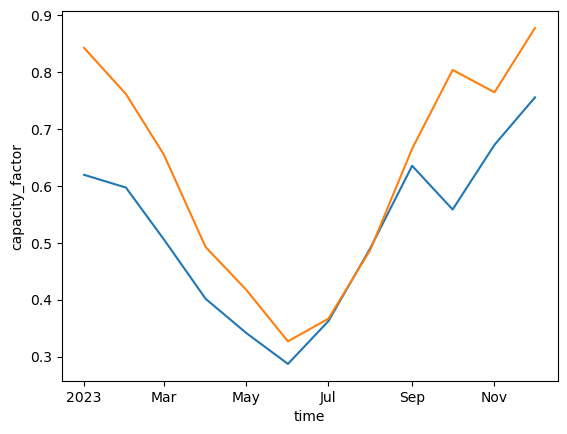

In [150]:
(aemo_solar.power.sel(region="NSW", time="2023") / 1e6).resample(time="1MS").sum().plot()
power_current.sum(["lat", "lon"]).resample(time="1MS").sum().plot()

In [155]:
obs_total = aemo_solar.power.sel(region="NSW", time="2023").sum() / 1e6
obs_total

<xarray.DataArray 'power' ()> Size: 8B
array(6.22952472)
Coordinates:
    region   <U3 12B 'NSW'

In [171]:
aemo_solar.power.sel(time="2023").sum() / 1e6

<xarray.DataArray 'power' ()> Size: 8B
array(14.38322688)

In [156]:
model_total = power_current.sum()
model_total

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(7.4638286, dtype=float32)

In [157]:
bias = model_total / obs_total
bias

<xarray.DataArray ()> Size: 8B
array(1.19813772)
Coordinates:
    region   <U3 12B 'NSW'

In [158]:
obs_total / model_total

<xarray.DataArray ()> Size: 8B
array(0.83462859)
Coordinates:
    region   <U3 12B 'NSW'

In [160]:
cf_r_bc = cf_r / bias

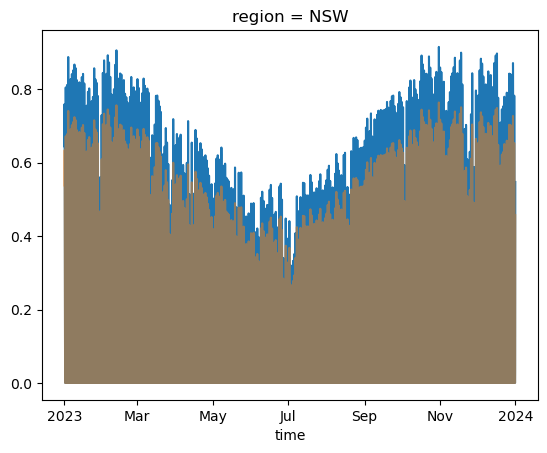

In [162]:
cf_r.mean(["lat", "lon"]).plot()
cf_r_bc.mean(["lat", "lon"]).plot(alpha=0.5)
# xr.where(cf_r_bc > 1, 1, cf_r_bc).mean(["lat", "lon"]).plot(alpha=0.5)

In [135]:
# (cf_r_bc.where(cf_r_bc > 1).count("time") / len(cf_r_bc.time.values) * 100).plot()

In [136]:
# cf_r_bc_clip = xr.where(cf_r_bc > 1, 1, cf_r_bc)

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(0.2091287, dtype=float32)
<xarray.DataArray ()> Size: 8B
array(0.1745447)
Coordinates:
    region   <U3 12B 'NSW'


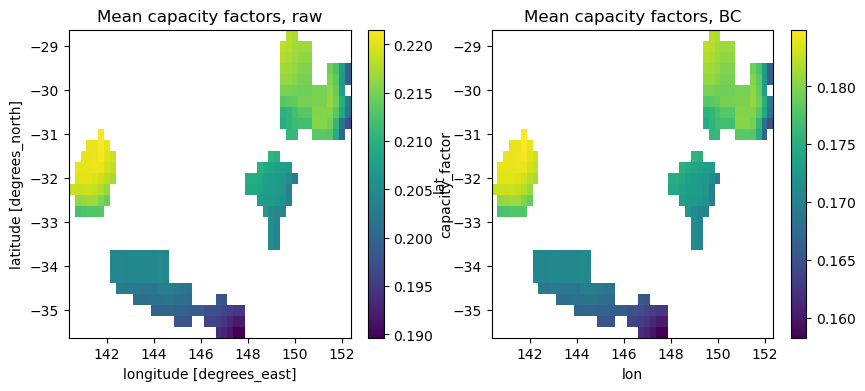

In [164]:
fig,ax=plt.subplots(1, 2, figsize=(10,4))

cf_r.mean("time").plot(ax=ax[0])
ax[0].set_title("Mean capacity factors, raw")

cf_r_bc.mean("time").plot(ax=ax[1])
ax[1].set_title("Mean capacity factors, BC")

print(cf_r.mean())
print(cf_r_bc.mean())
# print(cf_r_bc_clip.mean())

In [168]:
import numpy as np

In [166]:
power_current_bc = cf_r_bc * r_mask_current / 1e6
power_30_bc = cf_r_bc * r_mask_30 / 1e6

# power_current_bc_clip = cf_r_bc_clip * r_mask_current / 1e6
# power_30_bc_clip = cf_r_bc_clip * r_mask_30 / 1e6

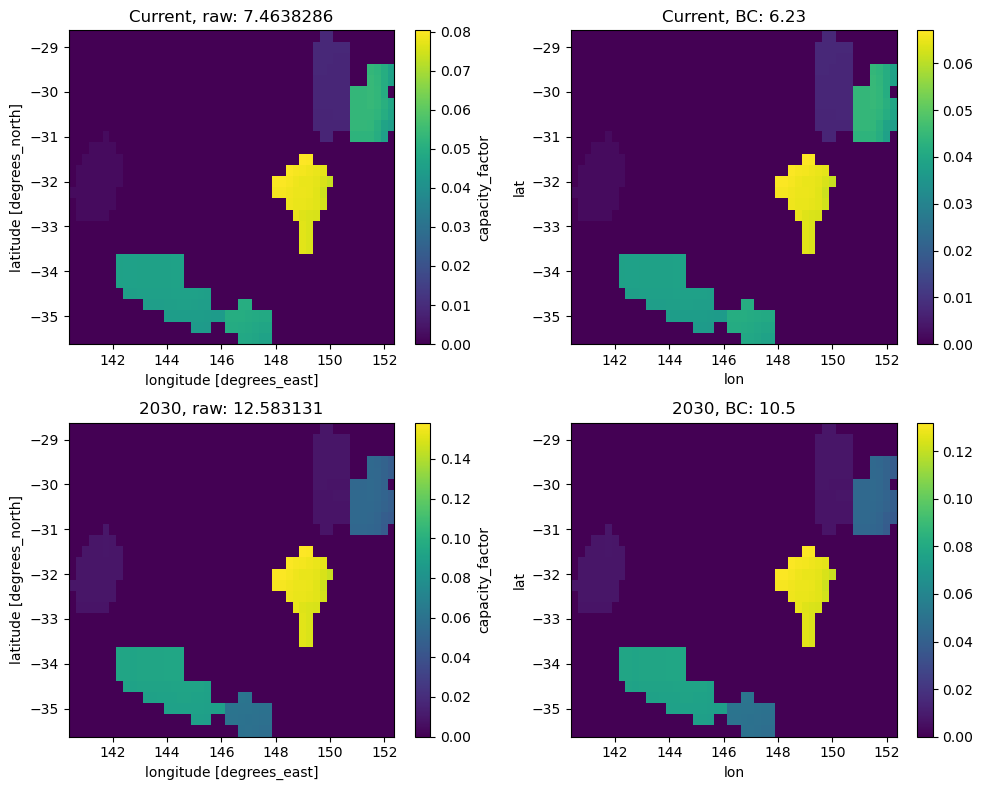

In [169]:
fig,ax=plt.subplots(2, 2, figsize=(10,8))

power_current.sum("time").plot(ax=ax[0,0])
ax[0,0].set_title("Current, raw: " + str(power_current.sum().values))

power_current_bc.sum("time").plot(ax=ax[0,1])
ax[0,1].set_title(
    "Current, BC: " + str(np.round(power_current_bc.sum().values, 2)))# + "\nClipped: "+ \
# str(np.round(power_current_bc_clip.sum().values, 2)) )

power_30.sum("time").plot(ax=ax[1,0])
ax[1,0].set_title("2030, raw: " + str(power_30.sum().values))

power_30_bc.sum("time").plot(ax=ax[1,1])
ax[1,1].set_title("2030, BC: " + str(np.round(power_30_bc.sum().values, 2)))# + "\nClipped: "+ \
# str(np.round(power_30_bc_clip.sum().values, 2)) )

plt.tight_layout()

For all NEM

In [172]:
r_mask_current = gen_capacity_current.where(gen_capacity_current.notnull(), drop=True)
r_mask_30 = gen_capacity_30.where(gen_capacity_30.notnull(), drop=True)

In [173]:
r_mask_current = r_mask_current.sum("REZ")
r_mask_30 = r_mask_30.sum("REZ")

### We have 9900 MW installed solar for 2023, compared to ~5000 according to OpenEl.

### For 2030, we have 13800 MW, but OpenEl has 16000
Our figures don't include sites outside REZs

Text(0.5, 1.0, '2030, MW: 13843.0')

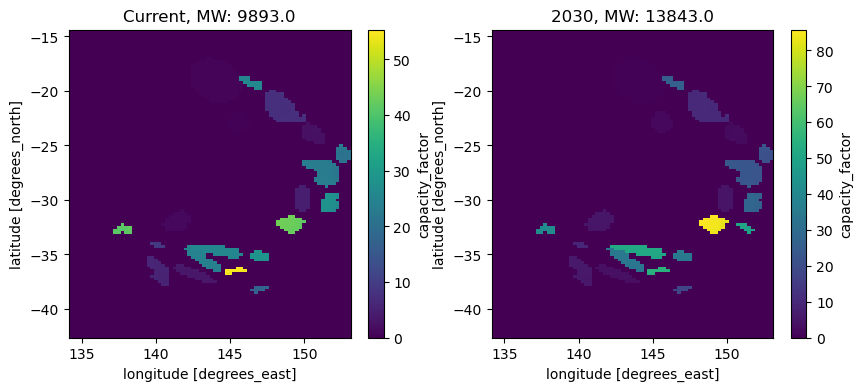

In [177]:
fig,ax=plt.subplots(1, 2, figsize=(10,4))
r_mask_current.plot(ax=ax[0])
ax[0].set_title("Current, MW: " + str(gen_capacity_current.sum().values))

r_mask_30.plot(ax=ax[1])
ax[1].set_title("2030, MW: " + str(gen_capacity_30.sum().values))

In [181]:
cf_r = cf.where(r_mask_current > 0, drop=True).compute()

In [182]:
power_current = (cf_r * r_mask_current) / 1e6
power_30 = (cf_r * r_mask_30) / 1e6

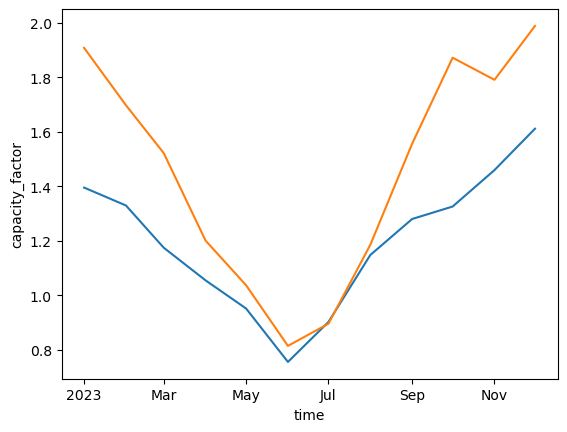

In [184]:
(aemo_solar.power.sum("region").sel(time="2023") / 1e6).resample(time="1MS").sum().plot()
power_current.sum(["lat", "lon"]).resample(time="1MS").sum().plot()

In [185]:
obs_total = aemo_solar.power.sum("region").sel(time="2023").sum() / 1e6
obs_total

<xarray.DataArray 'power' ()> Size: 8B
array(14.38322688)

In [186]:
model_total = power_current.sum()
model_total

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(17.465908, dtype=float32)

In [187]:
bias = model_total / obs_total
bias

<xarray.DataArray ()> Size: 8B
array(1.21432473)

In [158]:
obs_total / model_total

<xarray.DataArray ()> Size: 8B
array(0.83462859)
Coordinates:
    region   <U3 12B 'NSW'

In [160]:
cf_r_bc = cf_r / bias

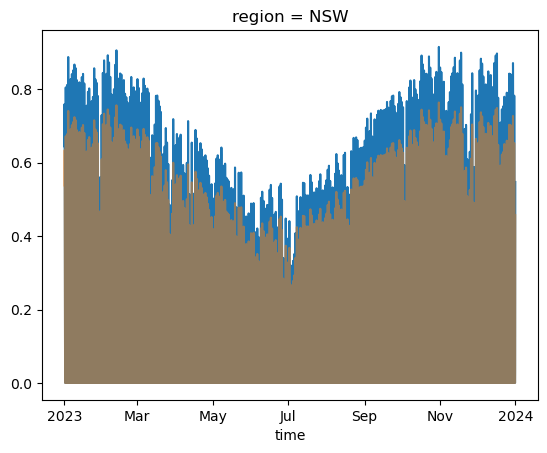

In [162]:
cf_r.mean(["lat", "lon"]).plot()
cf_r_bc.mean(["lat", "lon"]).plot(alpha=0.5)
# xr.where(cf_r_bc > 1, 1, cf_r_bc).mean(["lat", "lon"]).plot(alpha=0.5)

In [135]:
# (cf_r_bc.where(cf_r_bc > 1).count("time") / len(cf_r_bc.time.values) * 100).plot()

In [136]:
# cf_r_bc_clip = xr.where(cf_r_bc > 1, 1, cf_r_bc)

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(0.2091287, dtype=float32)
<xarray.DataArray ()> Size: 8B
array(0.1745447)
Coordinates:
    region   <U3 12B 'NSW'


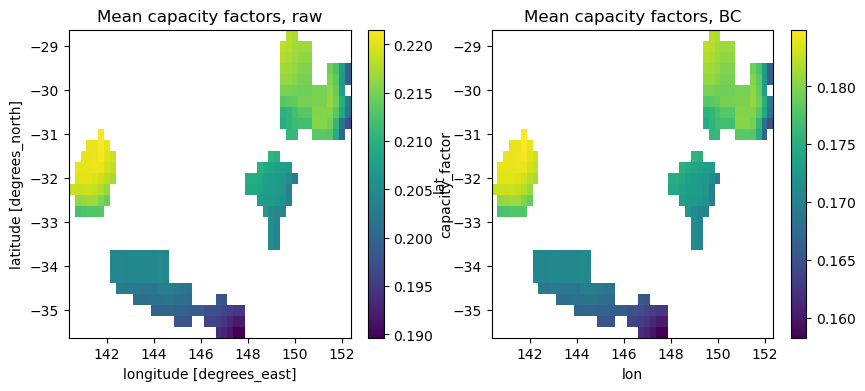

In [164]:
fig,ax=plt.subplots(1, 2, figsize=(10,4))

cf_r.mean("time").plot(ax=ax[0])
ax[0].set_title("Mean capacity factors, raw")

cf_r_bc.mean("time").plot(ax=ax[1])
ax[1].set_title("Mean capacity factors, BC")

print(cf_r.mean())
print(cf_r_bc.mean())
# print(cf_r_bc_clip.mean())

In [168]:
import numpy as np

In [166]:
power_current_bc = cf_r_bc * r_mask_current / 1e6
power_30_bc = cf_r_bc * r_mask_30 / 1e6

# power_current_bc_clip = cf_r_bc_clip * r_mask_current / 1e6
# power_30_bc_clip = cf_r_bc_clip * r_mask_30 / 1e6

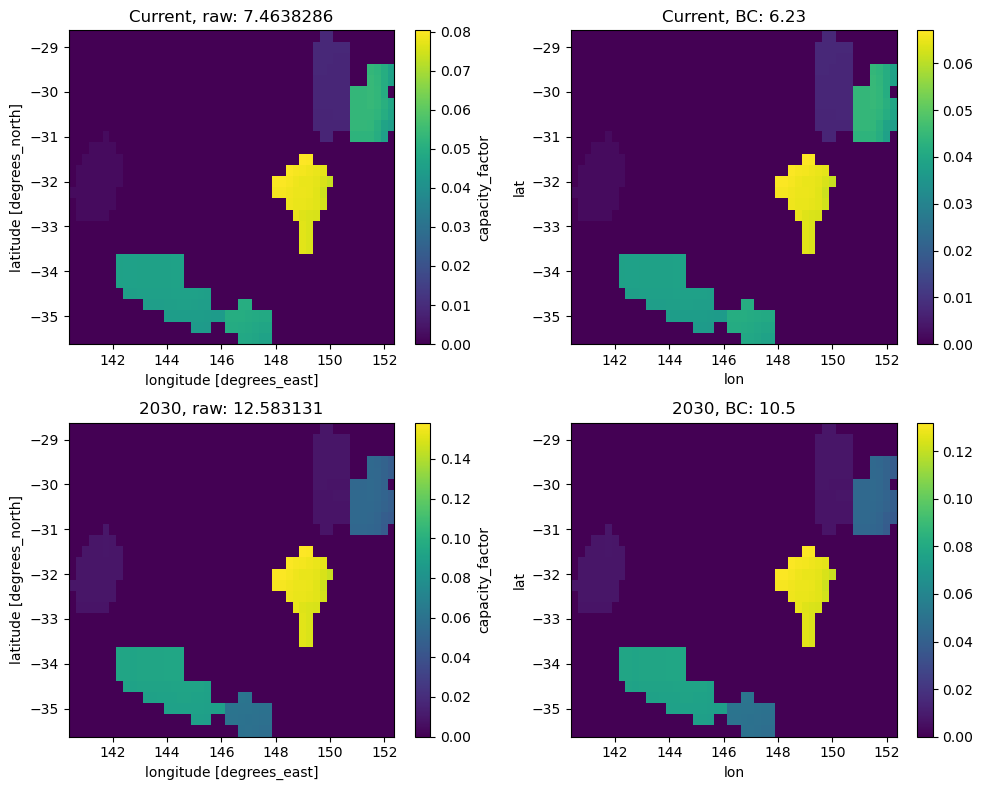

In [169]:
fig,ax=plt.subplots(2, 2, figsize=(10,8))

power_current.sum("time").plot(ax=ax[0,0])
ax[0,0].set_title("Current, raw: " + str(power_current.sum().values))

power_current_bc.sum("time").plot(ax=ax[0,1])
ax[0,1].set_title(
    "Current, BC: " + str(np.round(power_current_bc.sum().values, 2)))# + "\nClipped: "+ \
# str(np.round(power_current_bc_clip.sum().values, 2)) )

power_30.sum("time").plot(ax=ax[1,0])
ax[1,0].set_title("2030, raw: " + str(power_30.sum().values))

power_30_bc.sum("time").plot(ax=ax[1,1])
ax[1,1].set_title("2030, BC: " + str(np.round(power_30_bc.sum().values, 2)))# + "\nClipped: "+ \
# str(np.round(power_30_bc_clip.sum().values, 2)) )

plt.tight_layout()

# Close cluster

In [215]:
gen["Existing_solar"].sum()

9893

In [ ]:
client.close()
cluster.close()